Lecturer: Prof. Dr. Philipp Berens

Tutors: Jonas Beck, Ziwei Huang, Rita González Márquez

Summer term 2023

Name: FILL IN YOUR NAMES HERE

# Neural Data Science Project 01

## Working with Calcium data

In the following project you will recieve a data set, along with a set of questions. Use the methods that you have learned throughout this course to explore the data and to answer the questions. You are free to use tools, resources and libraries as you see fit. Use comments and markdown cells to document your thought process and to explain your reasoning. We encourage you to compare different algorithms or to implement state of the art solutions. The notebook should be self contained, although you may offload some functions to a `utils.py`. The notebook should be concluded with a final summary / conclusions section.

In [27]:
# import packages here

import numpy as np
import pandas as pd
import jupyter_black
import matplotlib.pyplot as plt

jupyter_black.load()

## Context
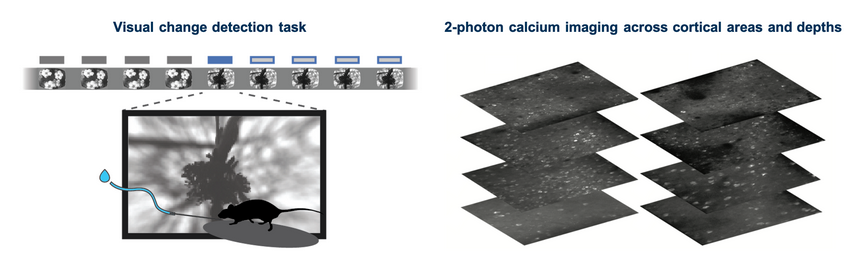

The data set that goes along with this notebook was recorded using in vivo 2-photon calcium imaging to measure the activity of genetically identified neurons in the visual cortex of mice performing a go/no-go visual change detection task. The data recordings stem from primary visual cortex and a GCaMP6f indicator was used. The data was recorded as follows.

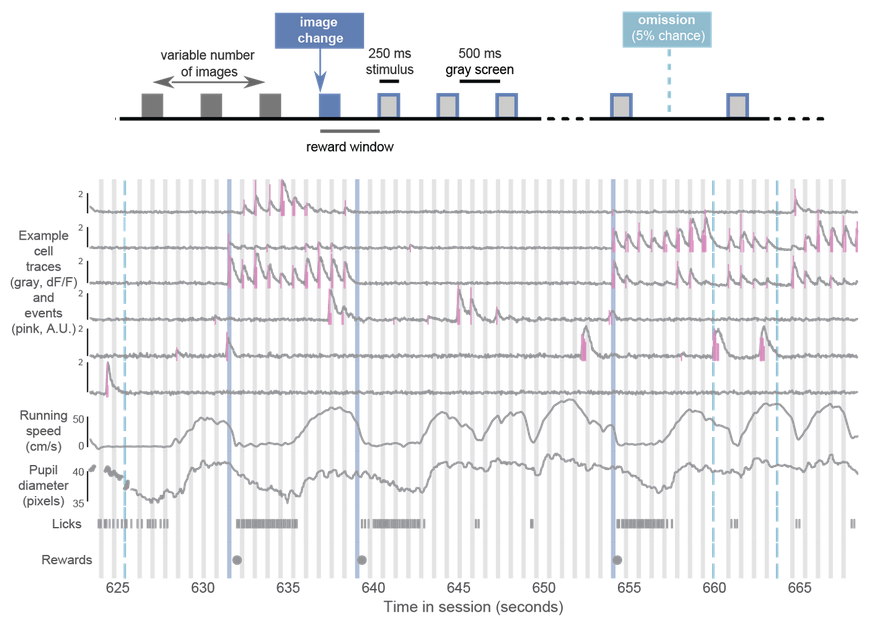

The data consists of:
- the preprocessed activity traces (df/f)
- the stimulus metadata
- the ROI masks for each cell
- a maximum activity projection of all ROIs
- running speed
- table of stimulus epochs

You will only work with a drifting grating stimulus.

Since the experiments were performed in sequence the calcium recordings that you receive also contain some other stimulus modalities (see `data["stim_epoch_table"]`). You can ignore these sections of the time-series data during analysis. Not all the data provided has to be used, however it can be incorporated into your analysis.

In [16]:
# load data
def load_data(path="."):
    def array2df(d, key, cols):
        d[key] = pd.DataFrame(d[key], columns=cols)

    data = np.load(path + "/dff_data_dsi.npz", allow_pickle=True)
    data = dict(data)
    array2df(
        data,
        "stim_table",
        ["temporal_frequency", "orientation", "blank_sweep", "start", "end"],
    )
    array2df(data, "stim_epoch_table", ["start", "end", "stimulus"])

    return data


def print_info(data):
    data_iter = ((k, type(v), v.shape) for k, v in data.items())
    l = [f"[{k}] - {t}, - {s}" for k, t, s in data_iter]
    print("\n".join(l) + "\n")


data = load_data()

print("Overview of the data")
print_info(data)
time_axis = data["t"]
dff_sequence = data["dff"]
stim_table = data["stim_table"]
stim_epoch_table = data["stim_epoch_table"]
roi_masks = data["roi_masks"]
max_projection = data["max_projection"]
running_speed = data["running_speed"]

Overview of the data
[t] - <class 'numpy.ndarray'>, - (115471,)
[dff] - <class 'numpy.ndarray'>, - (106, 115471)
[stim_table] - <class 'pandas.core.frame.DataFrame'>, - (628, 5)
[roi_masks] - <class 'numpy.ndarray'>, - (106, 512, 512)
[max_projection] - <class 'numpy.ndarray'>, - (512, 512)
[running_speed] - <class 'numpy.ndarray'>, - (2, 115471)
[stim_epoch_table] - <class 'pandas.core.frame.DataFrame'>, - (7, 3)



In [25]:
# print(data["stim_table"])
print(data["stim_epoch_table"])
print(running_speed[0, 115400])

                 start    end stimulus
0    drifting_gratings    747    18775
1  natural_movie_three  19709    37767
2    natural_movie_one  38671    47699
3    drifting_gratings  48602    66630
4          spontaneous  66780    75697
5  natural_movie_three  75698    93756
6    drifting_gratings  94659   115215
nan


106: number of cells \
115471: frames \
628: number of stims\
5: property of stims, temporal frequency orientation, blank sweep?, start, end\
512x512: size of image \
2: \
7: types of stims
||stimulus|start|end|
|---|---|---|---|
0|    drifting_gratings|    747|    18775|
1|  natural_movie_three|  19709|    37767|
2|    natural_movie_one|  38671|    47699|
3|    drifting_gratings|  48602|    66630|
4|          spontaneous|  66780|    75697|
5|  natural_movie_three|  75698|    93756|
6|    drifting_gratings|  94659|   115215|

3:

## Question

**Is there spatial structure in the preferred orientation/direction/spatial frequency?**

Implement all steps of the processing pipeline that are necessary to answer them. Think of: 
1. Pre-processing 
2. Spike inference 
3. Tuning function fitting 
4. Statistical testing. 

It is sufficient to assess spatial structure visually. Bonus points for proper statistical assessment. Also bonus points if you focus on specific cell types.

## 1. Preprocessing
**1.1. Downsample the data to ...** (not necessary, 30 Hz is not too high)\
**1.2. Signal correction to remove the artifact.**
**1.3. Compute the mean fluorescence of each ROI during the blank sweep**\
**1.4. Compute the mean fluorescence of each ROI during the stimulus presentation**

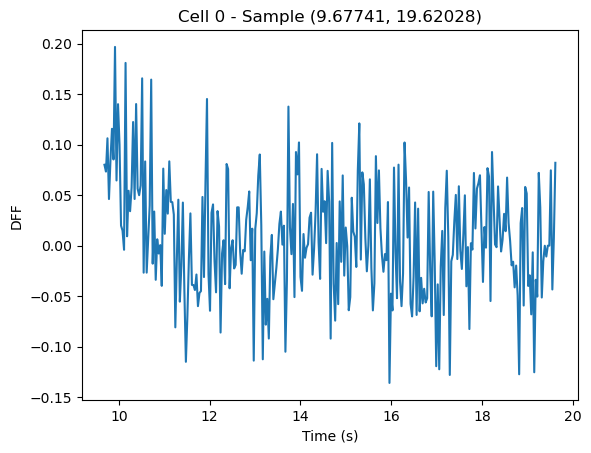

In [31]:
def plot_sample(t, dff, cell, sample):
    """
    Plot the sample time series of dff
    t: time axis
    dff: dff sequence
    cell: cell index
    sample: sample index
    """
    plt.plot(t[sample], dff[cell, sample])
    plt.xlabel("Time (s)")
    plt.ylabel("DFF")
    plt.title(f"Cell {cell} - Sample {np.min(t[sample]), np.max(t[sample])}")
    plt.show()


# plot_sample(time_axis, dff_sequence, 0, slice(0, 300))